# Project 1: Centrality Measures with Airports and Flight Routes
By Shyam Balagurumurthy and Latif Masud

# Introduction

For this project, we chose to look at a dataset of airports and airline routes. The dataset was taken from [OpenFlights](https://openflights.org/data.html) containing airports, routes, and airline information. Using this dataset, we built out both neo4j and networkX graphs, and performed various analyses on them. 

# Loading the Data

Below are the libraries we needed for the project. `networkx` `urllib`, `matplotlib`, `nxviz`, and `numpy` are all used for centrality measurement, while `basemap` is used for map visualization. `neo4j` is pulled in to drive the interaction between the database. 

In [31]:
import networkx as net
import urllib
import matplotlib.pyplot as plt
import pandas as pd
import nxviz as nv
import numpy as np
from operator import itemgetter
from mpl_toolkits.basemap import Basemap
from neo4j.v1 import GraphDatabase, basic_auth

We chose to use neo4j as our graph database of choice since it is easy to work with, has an user interface, and we have prior experience with it in the past. To start, we define a couple of functions to help us acquire the data. The `clean_line` function simply takes in a string, checks for a set of predefined invalid values, and eliminates those values from the string. This is done to ensure escape characters such as `\n` and `'` are taken out before we process on those strings. 

The `extract_data` function is the main function that performs the data extraction. It opens up a given file path, reads in the lines, and then converts the lines to a Python dictionary, which is then returned. There is a bit of functional programming used to make the code simpler. The `zip` function creates a pairwise list from two different arrays, so we define properties for each of the packages we want to look at. For example, when we are uploading airport information, we first define properties in `airport_props` with fields such as the `name`, `city`, `country`, etc that matchup exactly with the dataset. The `zip` function then lines up the values, and we create a dictionary from those values, which is then appended to a list. 

In [3]:
def clean_line(line):
    invalids = ['"', '\n']
    for n in invalids:
        line = line.replace(n, '')
        
    return line

def extract_data(file_loc, props):
    # Read in file
    file_obj = open(file_loc, "r",encoding="utf8")
    lines = file_obj.readlines()
    file_obj.close()
    

    #Takes the lines that were read in, does a split to create an array, then zips
    #with the props to create a 2d array, and then forms a dictionary from that 2d array,
    #and returns a list of those dictionaries.
    return list(map(lambda x: dict(zip(props, clean_line(x).split(","))), lines))
    

Below are the defined properties for airports, routes, and airlines. They are taken in by `extract_data` along with the file location to map through, and return dictionaries of the datasets. 

In [4]:
airport_props = [
        "airport_id",
        "name",
        "city",
        "country",
        "iata",
        "icao",
        "lat",
        "lon",
        "altitude",
        "timezone",
        "dst",
        "tz_database_time_zone",
        "type",
        "source"
]

route_props = [
        "airline",
        "airline_id",
        "source_airport",
        "source_airport_id",
        "destination_airport",
        "destination_airport_id",
        "codeshare",
        "stops",
        "equipment"
        ]

airlines_props = ["airline_id",
"name",
"alias",
"iata",
"icao",
"callsign",
"country",
"active"]

To extract the data into Python dictionaries, we simply call the `extract_data` function with the pre-ddefined props.

In [5]:
routes = extract_data("./data/routes.dat", route_props)
airports = extract_data("./data/airports.dat", airport_props)
airlines = extract_data('./data/airlines.dat',airlines_props)[1:]

Once we have the data, we startup our neo4j client. The password field has been left blank for privacy concerns.

In [ ]:
driver = GraphDatabase.driver("bolt://localhost:7687", auth=basic_auth("neo4j", ""))
session = driver.session()

For each airport, we run the following Cypher query with our connection. We predefine the properties in the query to match the data shape that was defined in `airport_props`, and simply pass along the reference from the loop as `airport`. 

In [ ]:
for airport in airports:
    session.run(
        """CREATE (a:Airport {
            airport_id: {airport_id},
            name: {name},
            city: {city},
            country: {country},
            iata: {iata},
            icao: {icao},
            lat: {lat},
            lon: {lon},
            altitude: {altitude},
            timezone: {timezone},
            dst: {dst},
            tz_database_time_zone: {tz_database_time_zone},
            type: {type},
            type: {source}})""", airport)

Once we have inserted the airports, we can then insert the routes between the airports. We do this by running through the routes in similar fashion as the airports. Once we enter the routes, we choose to link the airports related to that route by running a couple of matches, and creating links between that route and the airports. 

In [ ]:
for route_info in routes:
    route = {"destination": route_info["destination_airport"], "source": route_info["source_airport"]}
    session.run("MATCH(n: Airport {iata: {destination}}) MATCH(v: Airport {iata: {source}}) CREATE (n)-[:flies_to]->(v)", route)

    session.run(
        """CREATE (a:Route {
            airline: {airline},
            airline_id: {airline_id},
            source_airport: {source_airport},
            source_airport_id: {source_airport_id},
            destination_airport: {destination_airport},
            destination_airport_id: {destination_airport_id},
            codeshare: {codeshare},
            stops: {stops},
            equipment: {equipment}})
        """, route_info)

    session.run("MATCH(n: Airport {iata: {source}}) MATCH(v: Route {source_airport: {source}}) CREATE (n)-[:route]->(v)", route)
    session.run("MATCH(n: Airport {iata: {destination}}) MATCH(v: Route {destination_airport: {destination}}) CREATE (n)-[:route]->(v)", route)

When done, we can go on the neo4j web client, and take a look at our data with the following query: 

In [ ]:
MATCH (n) RETURN n

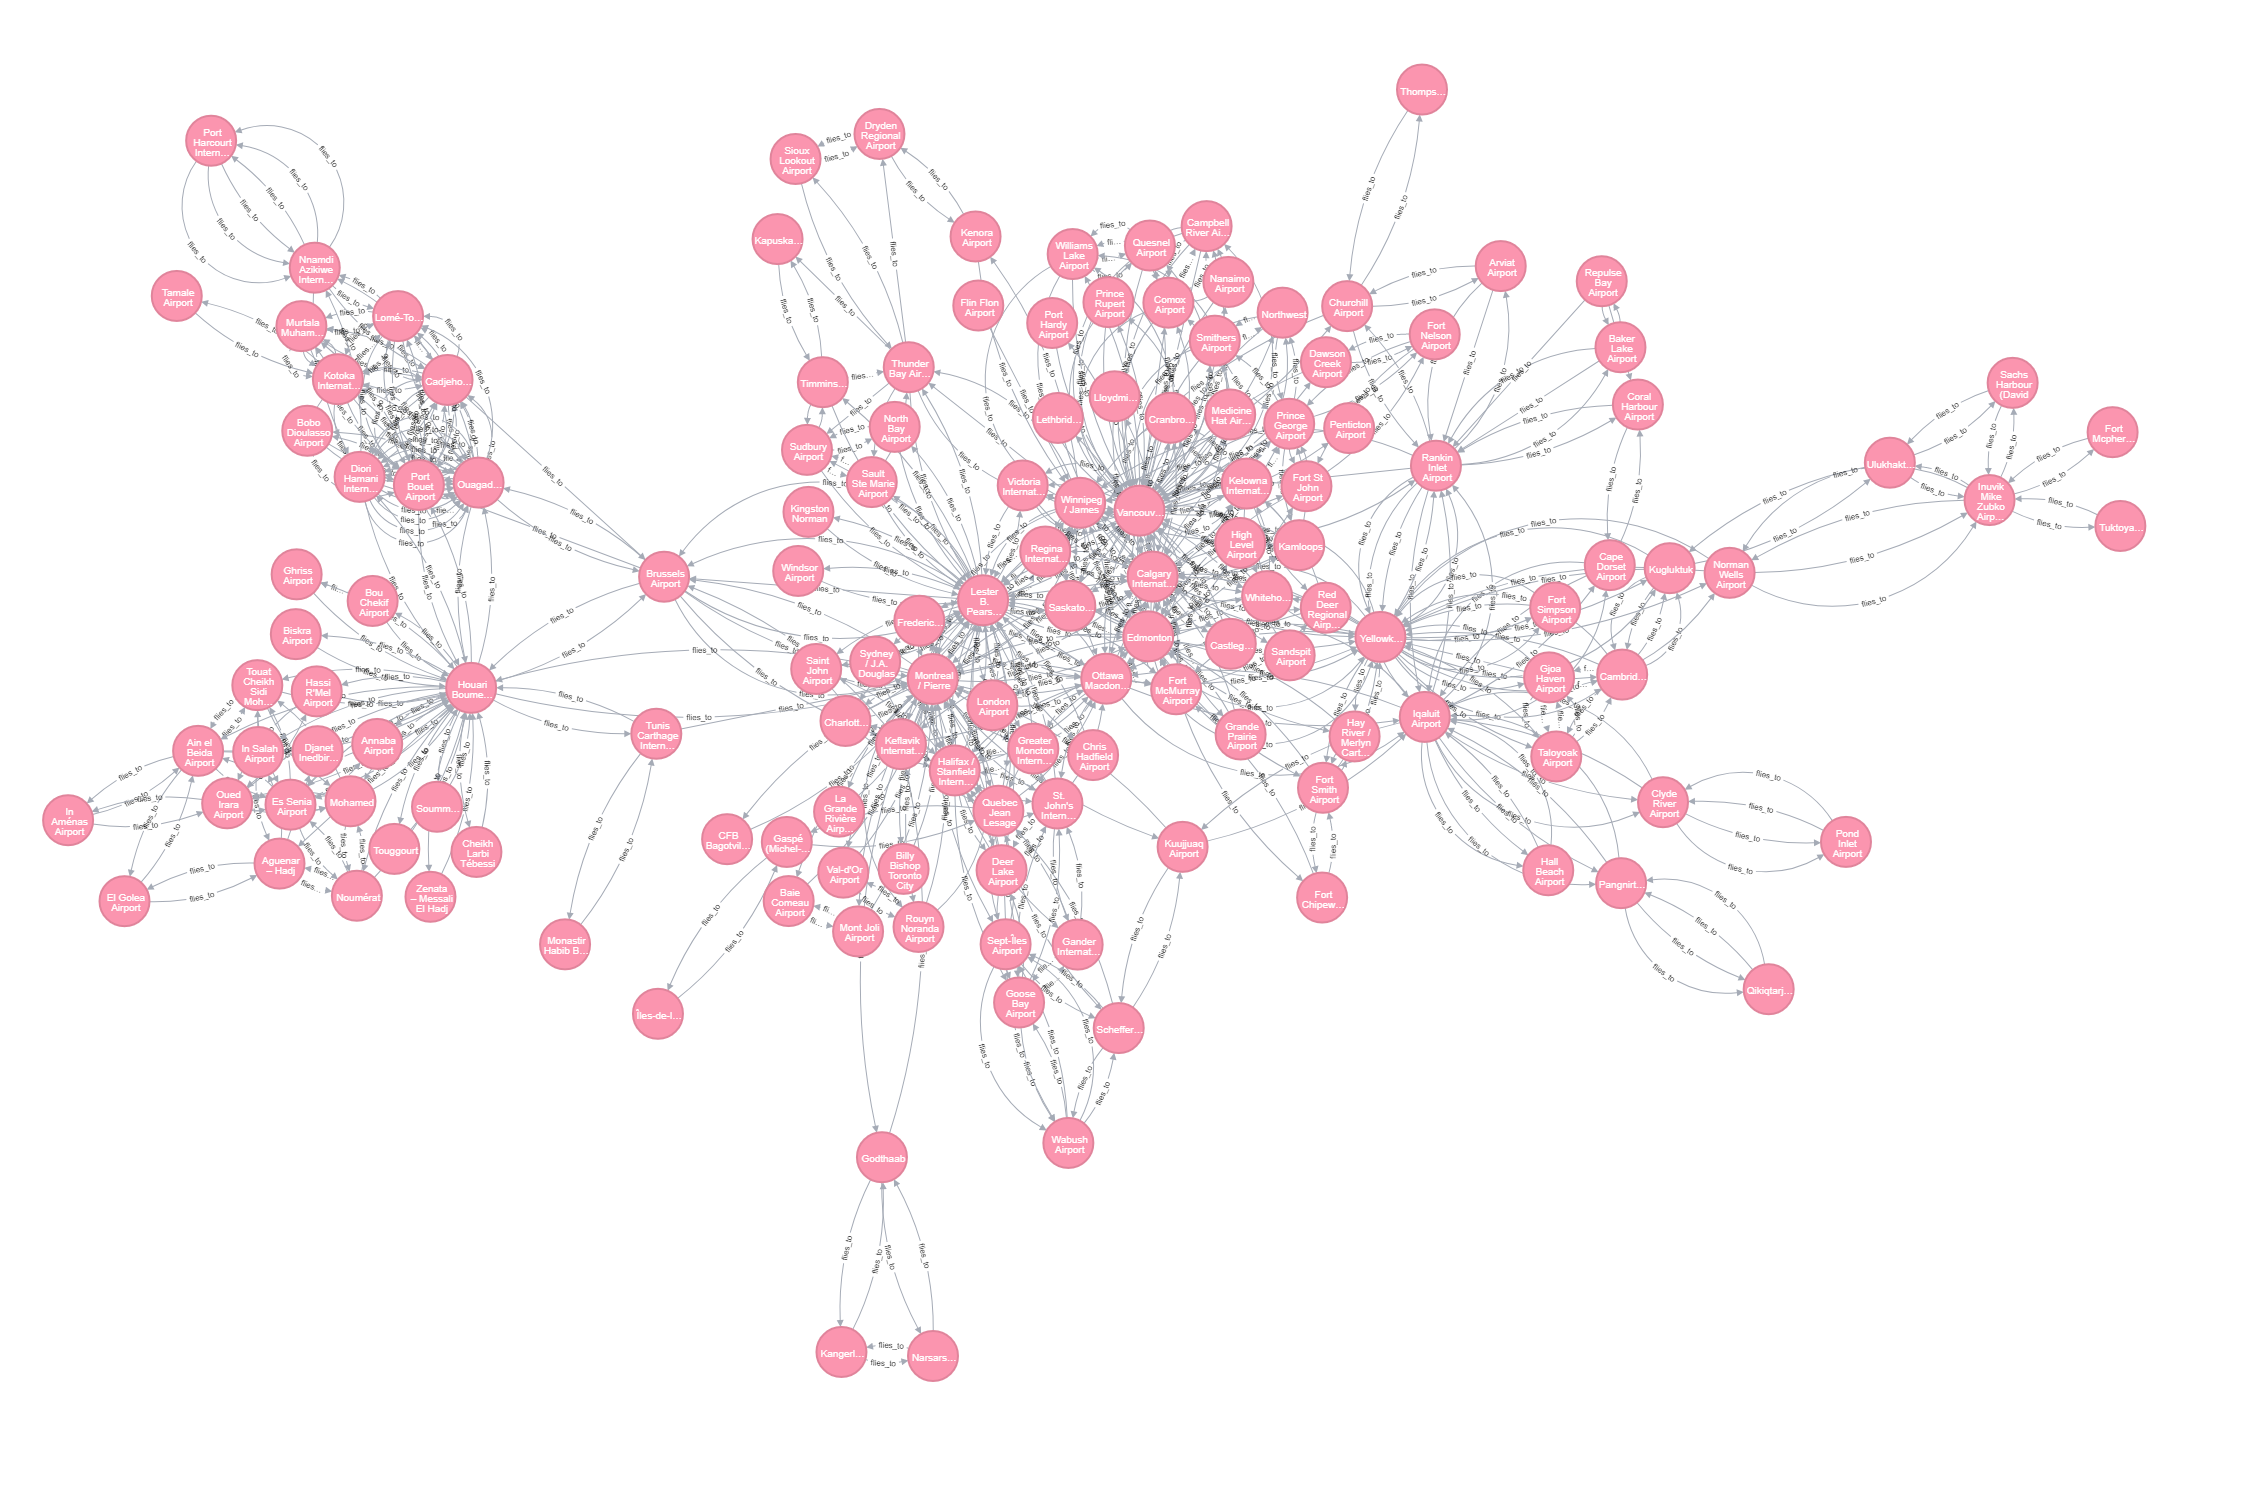

In [2]:
from IPython.display import Image
Image("img/initial_graph.png")

# Centrality

In [6]:
routes_df = pd.DataFrame(routes)
airlines_df = pd.DataFrame(airlines)

In [7]:
routes_airline = routes_df.merge(airlines_df,left_on="airline_id",right_on="airline_id",how="inner")[['airline', 'airline_id', 'codeshare', 'destination_airport',
       'destination_airport_id', 'equipment', 'source_airport',
       'source_airport_id', 'stops','name','active']].to_dict(orient='records')

In [1]:
g=net.DiGraph()

NameError: name 'net' is not defined

In [9]:
for airport in airports:
    g.add_node(airport['iata'], name= airport['name'], city= airport['city'], timezone = airport['timezone'], lat = airport['lat'], lon = airport['lon'])

In [10]:
for route in routes_airline:
    g.add_edge(route['source_airport'],route['destination_airport'], \
               stops =route['stops'],equipment=route['equipment'], airline_id =route['airline_id'], 
              name = route['name'], active =route['active'])

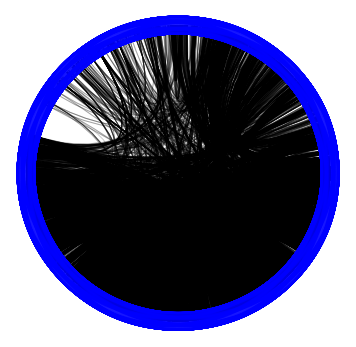

In [11]:
circos_plot = nv.CircosPlot(g)
circos_plot.draw()
plt.show()

In [12]:
def sorted_map(map1):
    ms = sorted(map1.items(), key =lambda k: -k[1])
    return ms

In [13]:
cs = net.closeness_centrality(g)
c = sorted_map(cs)
deg = net.degree(g)
d = sorted_map(deg)
bs = net.betweenness_centrality(g)
b = sorted_map(bs)

In [14]:
names1 = [x[0] for x in cs[:10]]
names2 = [x[0] for x in deg[:10]]
names3 = [x[0] for x in bs[:10]]

TypeError: unhashable type: 'slice'

In [ ]:
names = list(set(names1) | set(names2) | set(names3))

table = [[name,cs[name], deg[name], bs[name]] for name in names]
table

In [ ]:
#Eigen Vector centrality

eigen_vector = net.eigenvector_centrality(g)
eigen_vector_sorted = sorted_map(eigen_vector)
eigen_vector_sorted

# Shortest Path and Distance

In [12]:
from math import radians, cos, sin, asin, sqrt
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    km = 6367 * c
    return km

In [13]:
def calculate_distance(g, source,destination):
    """Calculate the distance between two direct locations"""
    mykeys = ('lat','lon')
    myvalues = (*itemgetter(*mykeys)(g.node[source]),*itemgetter(*mykeys)(g.node[destination]))
    myvalues =[float(x) for x in list(myvalues)]
    return(haversine(*myvalues))

In [36]:
def calculate_distance_chart(g, source,destination):
    """Calculate the distance between two direct locations"""
    mykeys = ('lat','lon')
    myvalues = (*itemgetter(*mykeys)(g.node[source]),*itemgetter(*mykeys)(g.node[destination]))
    myvalues =[float(x) for x in list(myvalues)]
    return(plot_chart(*myvalues))

C:\ProgramData\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:3274: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
C:\ProgramData\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:3283: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


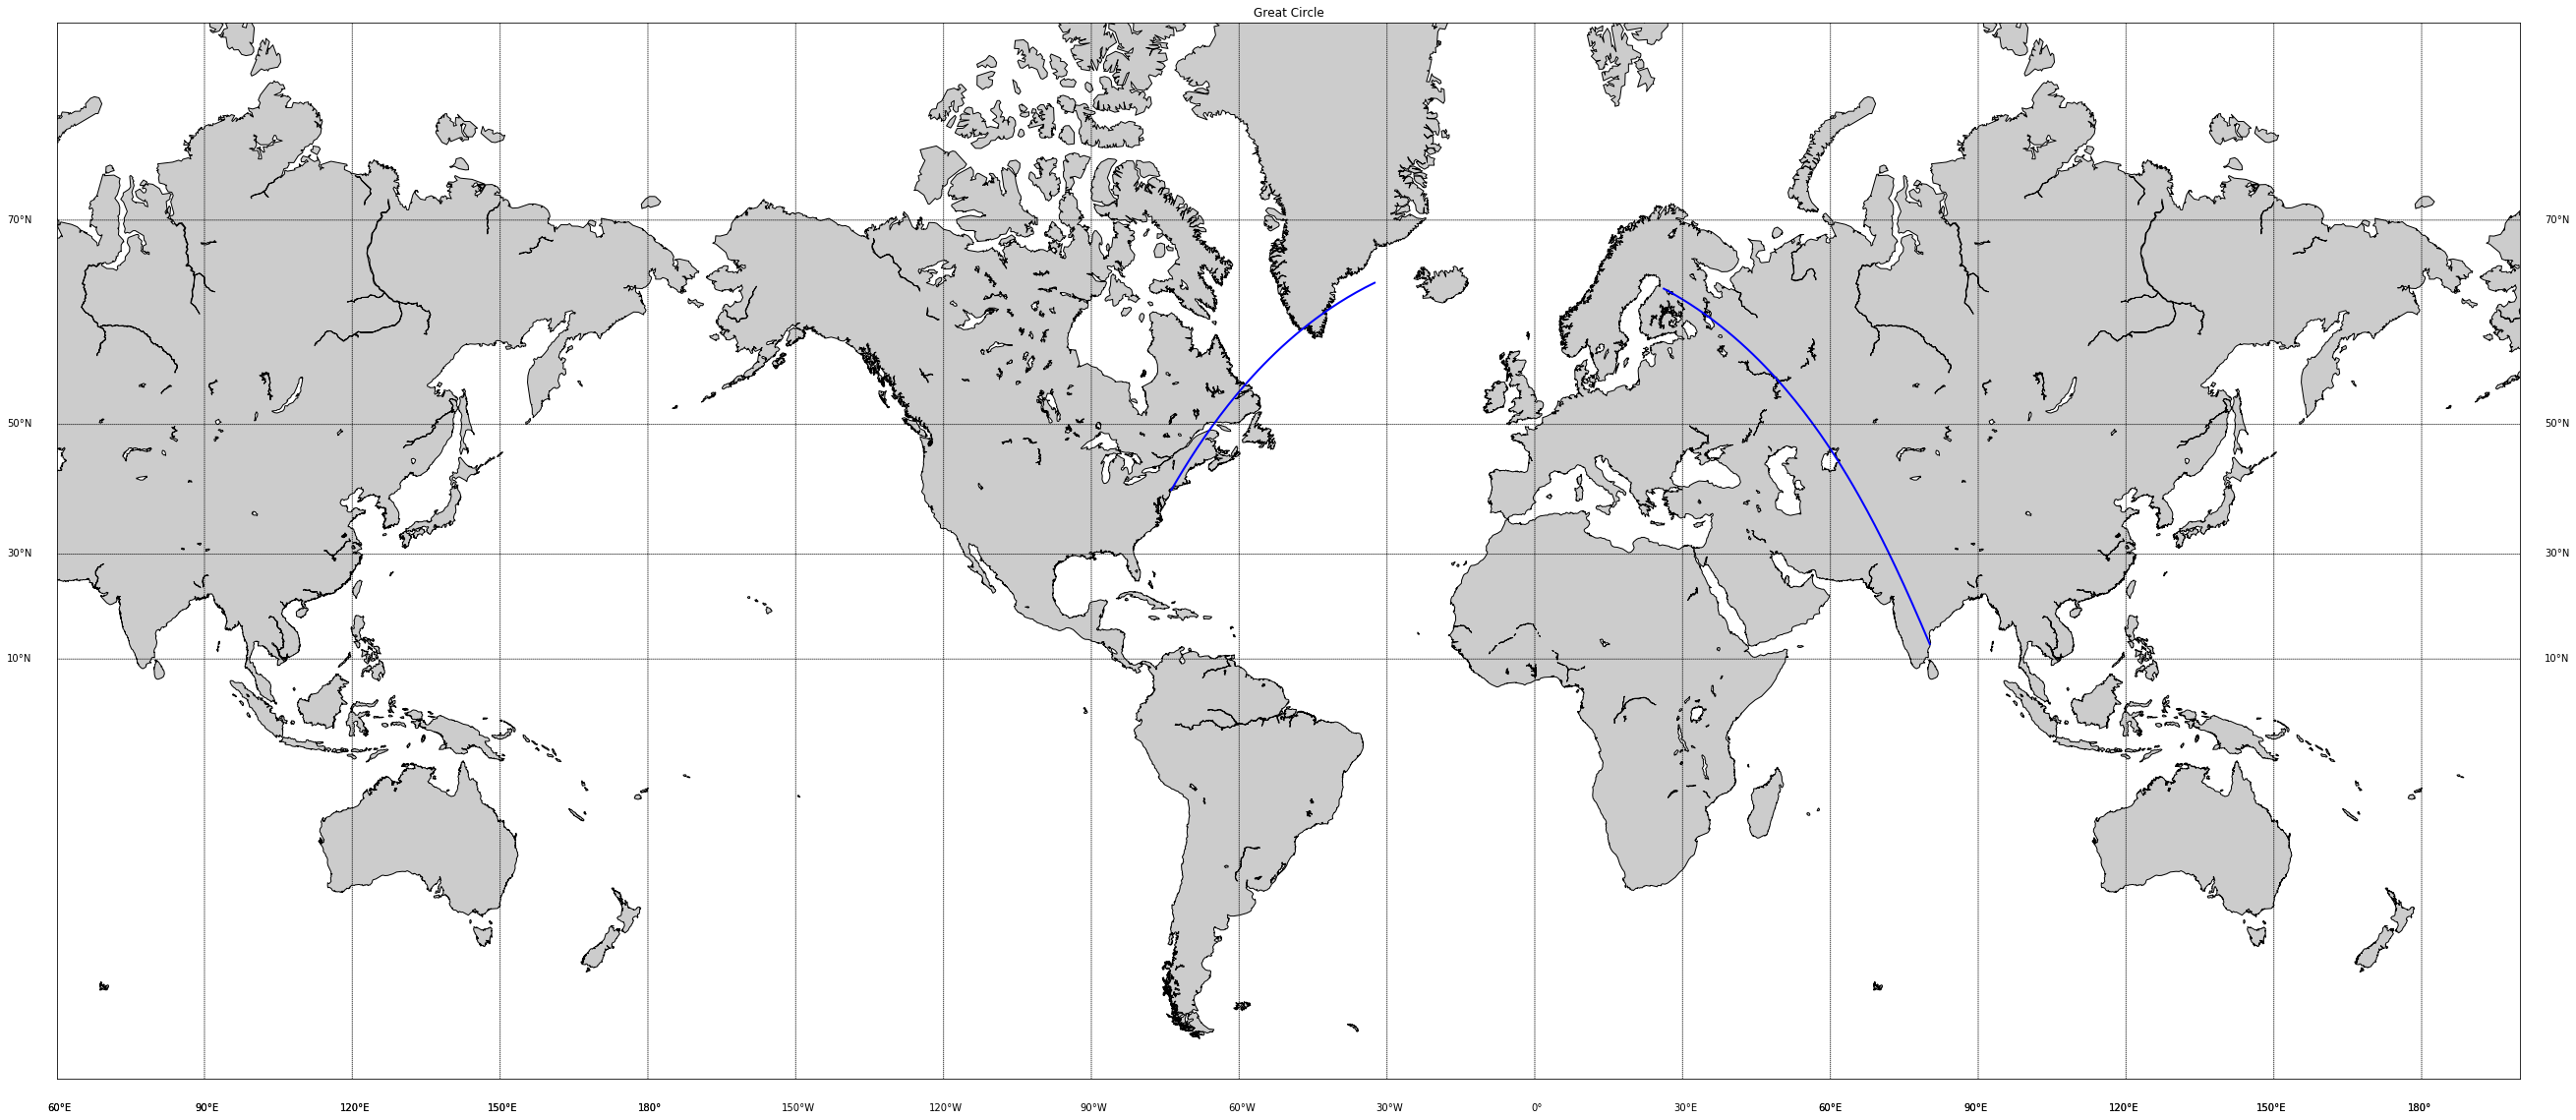

In [74]:
def plot_chart(lon1, lat1, lon2, lat2):
    # create new figure, axes instances.
    fig=plt.figure()
    ax=fig.add_axes([2.9,2.9,5.8,5.8])
    # setup mercator map projection.
    m = Basemap(llcrnrlon=-300.,llcrnrlat=-60.,urcrnrlon=200.,urcrnrlat=80.,\
                rsphere=(6378137.00,6356752.3142),\
                resolution='l',projection='merc',\
                lat_0=40.,lon_0=-20.,lat_ts=20.)
    # nylat, nylon are lat/lon of New York
    nylat = lon1; nylon = lat1
    # lonlat, lonlon are lat/lon of London.
    lonlat = lon2; lonlon = lat2
    # draw great circle route between NY and London
    m.drawgreatcircle(nylon,nylat,lonlon,lonlat,linewidth=2,color='b')
    m.drawcoastlines()
    m.fillcontinents()
    # draw parallels
    m.drawparallels(np.arange(10,90,20),labels=[1,1,0,1])
    # draw meridians
    m.drawmeridians(np.arange(-180,180,30),labels=[1,1,0,1])
    ax.set_title('Great Circle')
    plt.figure(figsize=(20,10))
    plt.show()


In [14]:
def calculate_distance1(g, travel_list):
    """Calculate the distance between two different locations"""
    if len(travel_list) ==2:
        source = travel_list[0]
        destination = travel_list[1]
        mykeys = ('lat','lon')
        myvalues = (*itemgetter(*mykeys)(g.node[source]),*itemgetter(*mykeys)(g.node[destination]))
        myvalues =[float(x) for x in list(myvalues)]
        return(haversine(*myvalues))
    
    else:
        total_km = []
        for i in np.arange(0,len(travel_list)-1):
            total_km.append(calculate_distance1(g, [travel_list[i], travel_list[i+1]]))
        total_km_num = sum(total_km)        
    return(total_km_num)

Enter Souce Airport: RDU
Enter Destination Airport: HNL

All different paths: [(['RDU', 'DFW', 'HNL'], 8810.000121065199), (['RDU', 'JFK', 'HNL'], 9827.116758512393), (['RDU', 'LAX', 'HNL'], 8898.892899944272), (['RDU', 'ORD', 'HNL'], 8780.679901240772), (['RDU', 'ATL', 'HNL'], 8781.00516185352), (['RDU', 'LAS', 'HNL'], 8914.478686174412), (['RDU', 'SLC', 'HNL'], 8964.153363119925), (['RDU', 'SFO', 'HNL'], 9006.85168602828), (['RDU', 'EWR', 'HNL'], 9743.189365604867), (['RDU', 'IAD', 'HNL'], 9044.483131642692), (['RDU', 'IAH', 'HNL'], 8798.752627009397), (['RDU', 'DEN', 'HNL'], 8888.387275541118), (['RDU', 'PHX', 'HNL'], 8861.285127770392)]

Minimum Distance of 8781 path is ['RDU', 'ORD', 'HNL']

Maximum Distance of 9827 path is ['RDU', 'JFK', 'HNL']

Dijkstra Path: ['RDU', 'DFW', 'HNL']


C:\ProgramData\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:3274: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
C:\ProgramData\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:3283: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


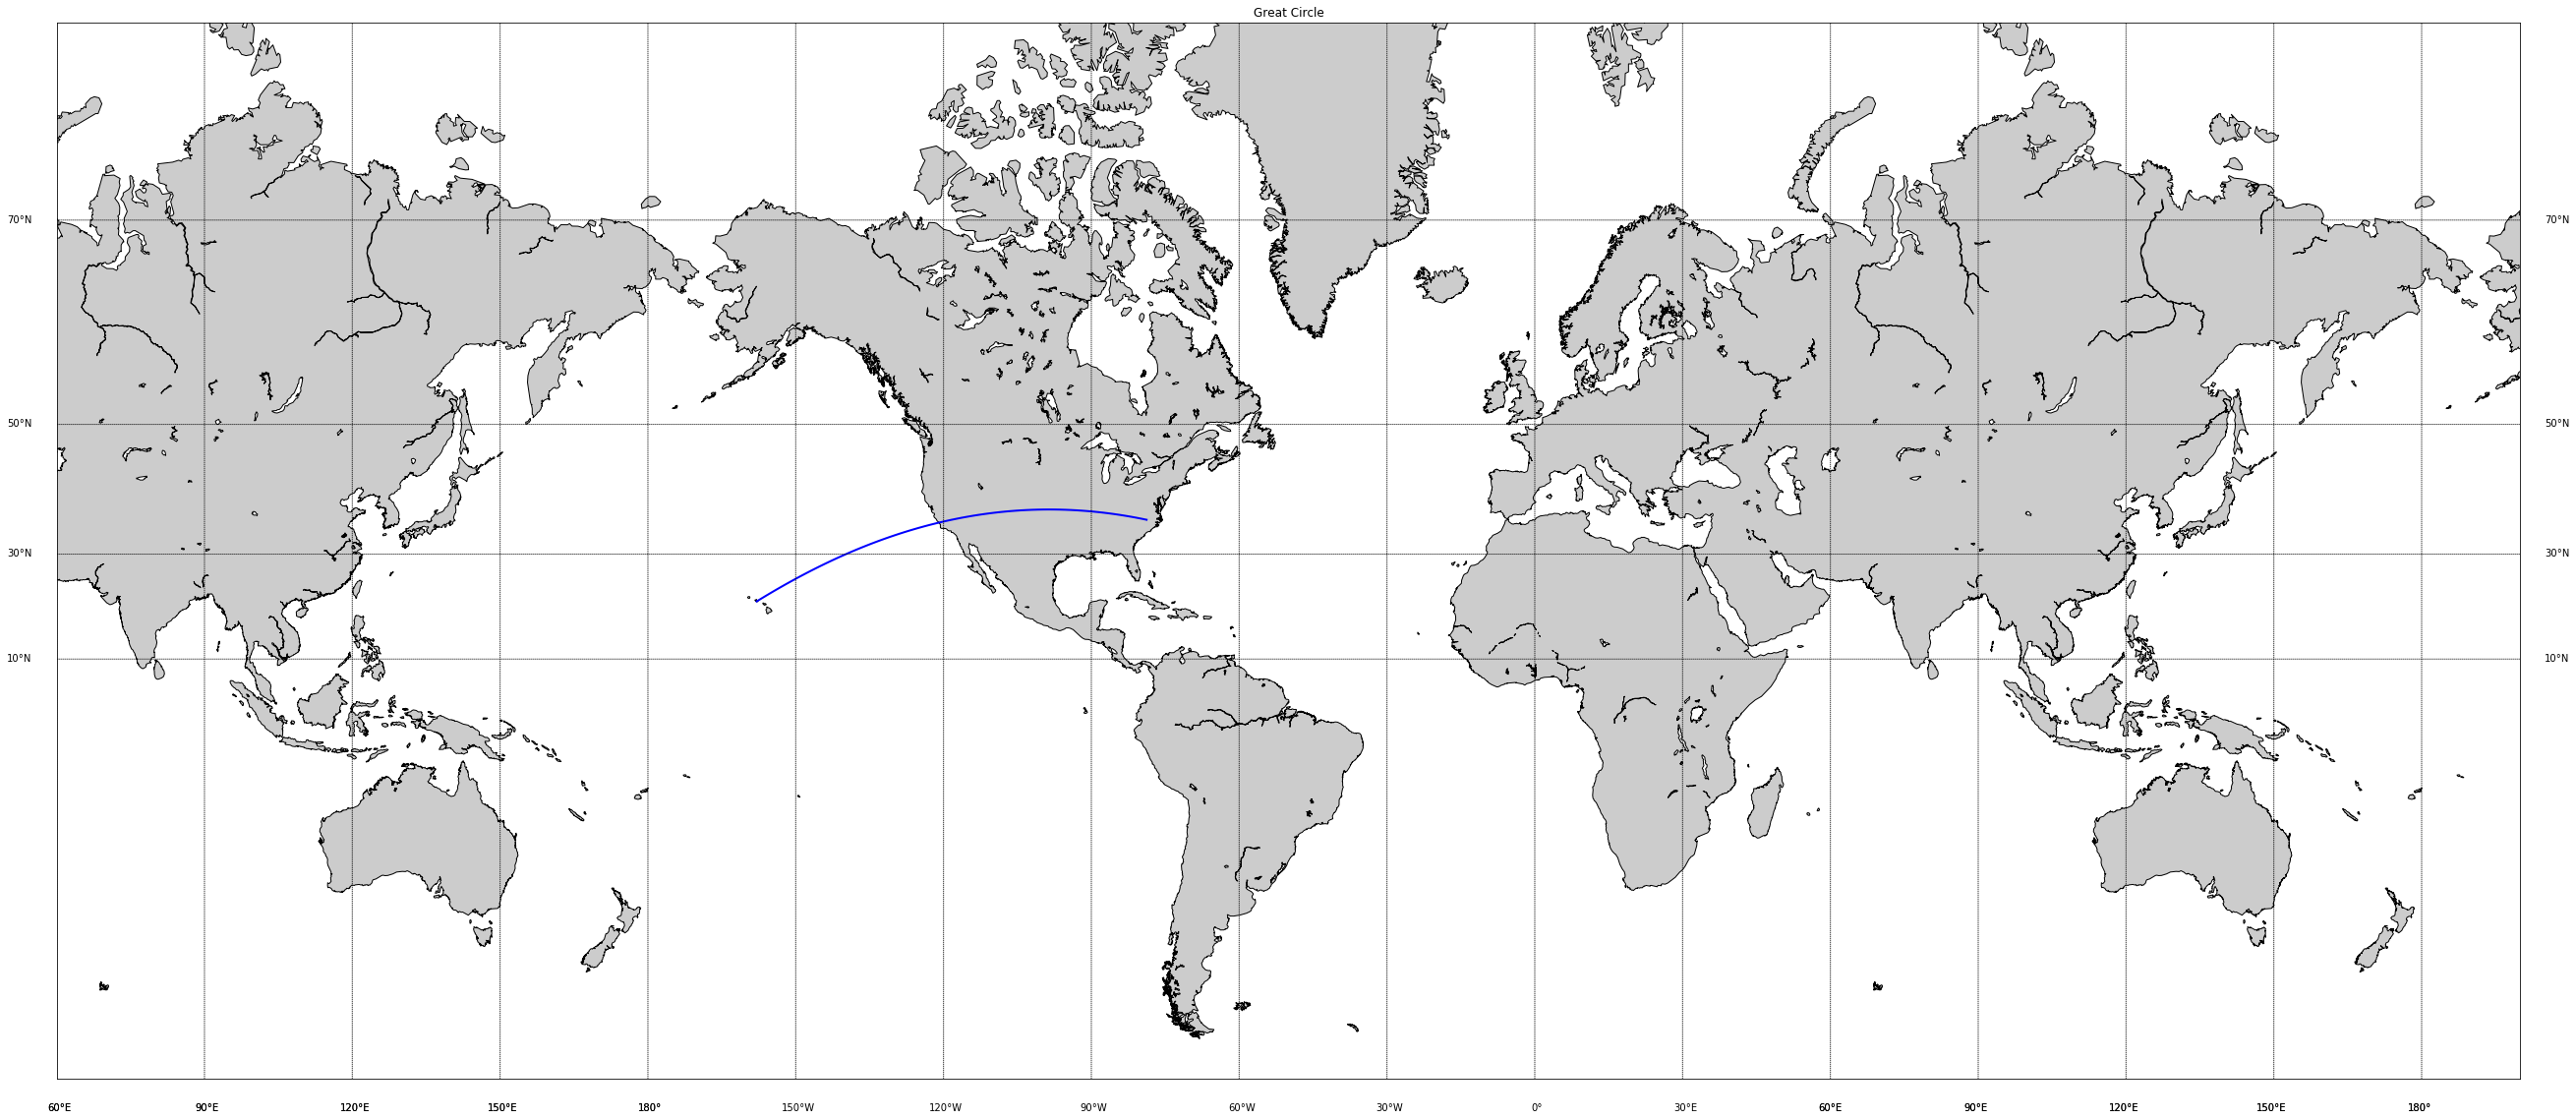

In [83]:
if __name__ == "__main__":
    source = input("Enter Souce Airport: ")
    destination = input("Enter Destination Airport: ")
    
    all_path = list(net.all_shortest_paths(g, source,destination))
    total_distances = [calculate_distance1(g,path) for path in all_path]
    
    #Calculate the min and max distance path
    min_distance_path = all_path[total_distances.index(min(total_distances))]
    max_distance_path = all_path[total_distances.index(max(total_distances))]
    
    
    print("\nAll different paths: {}".format(list(zip(all_path,total_distances))))
    print("\nMinimum Distance of {} path is {}".format(round(min(total_distances)), min_distance_path))    
    print("\nMaximum Distance of {} path is {}".format(round(max(total_distances)), max_distance_path))
    print("\nDijkstra Path: {}".format(net.dijkstra_path(g, source,destination)))
    
        
    calculate_distance_chart(g,source,destination)

In [84]:
g.edges(data=True)

[('GKA',
  'HGU',
  {'active': 'Y',
   'airline_id': '1308',
   'equipment': 'DH8 DHT',
   'name': 'Airlines PNG',
   'stops': '0'}),
 ('GKA',
  'LAE',
  {'active': 'Y',
   'airline_id': '1308',
   'equipment': 'DH8',
   'name': 'Airlines PNG',
   'stops': '0'}),
 ('GKA',
  'MAG',
  {'active': 'Y',
   'airline_id': '1308',
   'equipment': 'DH8',
   'name': 'Airlines PNG',
   'stops': '0'}),
 ('GKA',
  'POM',
  {'active': 'Y',
   'airline_id': '328',
   'equipment': 'DH4 DH8 DH3',
   'name': 'Air Niugini',
   'stops': '0'}),
 ('MAG',
  'GKA',
  {'active': 'Y',
   'airline_id': '1308',
   'equipment': 'DH8',
   'name': 'Airlines PNG',
   'stops': '0'}),
 ('MAG',
  'HGU',
  {'active': 'Y',
   'airline_id': '1308',
   'equipment': 'DH8',
   'name': 'Airlines PNG',
   'stops': '0'}),
 ('MAG',
  'LAE',
  {'active': 'Y',
   'airline_id': '1308',
   'equipment': 'DH8',
   'name': 'Airlines PNG',
   'stops': '0'}),
 ('MAG',
  'WWK',
  {'active': 'Y',
   'airline_id': '328',
   'equipment': '100